In [81]:
# Dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import stats
import seaborn as sns
pip freeze | grep (dependency) >> requirements.txt

NameError: name 'pipfreeze' is not defined

In [64]:
# Load in csv
filepath = os.path.join("CSV Files\\TWFC CSV\\Employment.csv")
employment_numbers_df = pd.read_csv(filepath)
filepath = os.path.join("CSV Files\\TWFC CSV\\Un_numbers.csv")
unemployment_numbers_df = pd.read_csv(filepath)
filepath = os.path.join("CSV Files\\TWFC CSV\\Un_rate.csv")
unemployment_rate_df = pd.read_csv(filepath)
filepath = os.path.join("CSV Files\TWFC CSV\\Laborforce.csv")
laborforce_df = pd.read_csv(filepath)
filepath = os.path.join("CSV Files\\TWFC CSV\\Income.csv")
income_df = pd.read_csv(filepath)
filepath = os.path.join("CSV Files\\TWFC CSV\\Population.csv")
population_df = pd.read_csv(filepath)
filepath = os.path.join("CSV Files\\Zillow CSV\\Price.csv")
price_df = pd.read_csv(filepath)
filepath = os.path.join("CSV Files\\Zillow CSV\\Rent.csv")
rent_df = pd.read_csv(filepath)

Texas Workforce Commission Clean Up

In [65]:
# Merge the monthly CSVs
merge_df = pd.merge(employment_numbers_df, unemployment_numbers_df, how="outer", on=["Year", "Period ID", "Period", "Area"])
merge_df2 = pd.merge(merge_df, unemployment_rate_df, how="outer", on=["Year", "Period ID", "Period", "Area"])
merge_df3 = pd.merge(merge_df2, laborforce_df, how="outer", on=["Year", "Period ID", "Period", "Area"])

In [66]:
# Select desired columns 
merge_df = merge_df3.drop(merge_df3.columns[[2,4,6,8,10]], axis=1)

# Change column name of Area to City
merge_df=merge_df.rename(columns = {"Area":"City", "Period ID": "Month"})

# Slice out MSA out of the City Names
merge_df["City"] = merge_df["City"].replace(" MSA","",regex=True)
merge_df = merge_df

# Convert Strings to Floats
merge_df["Employment"] = merge_df["Employment"].replace(",","",regex=True).astype("float")
merge_df["Unemployment"] = merge_df["Unemployment"].replace(",","",regex=True).astype("float")
merge_df["Labor Force"] = merge_df["Labor Force"].replace(",","",regex=True).astype('float')

#Clean up city names
merge_df["City"], merge_df["x"] = merge_df["City"].str.split("-", 2).str[0:2].str
merge_df = merge_df.drop(merge_df.columns[[-1]], axis=1)

Zillow Data Clean Up

In [67]:
# Convert Region Name into Seperate City and State Columns
rent_df["City"],rent_df["State"] = rent_df["RegionName"].str.split(",", 2).str[0:2].str
rent_df['State'].replace(' TX','TX', inplace=True)
price_df["City"],price_df["State"] = price_df["RegionName"].str.split(",", 2).str[0:2].str
price_df["State"].replace(" TX","TX", inplace=True)

# Extract only the Texas Data
rent_tx_df = rent_df.loc[rent_df["State"] == "TX", :]
rent_tx_df = rent_tx_df.set_index("City")
price_tx_df = price_df.loc[price_df["State"] == "TX", :]
price_tx_df = price_tx_df.set_index("City")

# Remove Undesired Columns
rent_tx_df = rent_tx_df.drop(rent_tx_df.columns[[0,1,2,-1]], axis=1)
price_tx_df = price_tx_df.drop(price_tx_df.columns[[0,1,-1]], axis=1)

# Transpose Data Frame
rent = rent_tx_df.transpose()
price = price_tx_df.transpose()

#Move the Index
rent.reset_index(level=0, inplace=True)
rent = rent.rename(columns = {"index":"Date"})
rent = rent.reset_index(drop=True)
price.reset_index(level=0, inplace=True)
price = price.rename(columns = {"index":"Date"})
price = price.reset_index(drop=True)

# Convert the Date into a Month and Year Column
rent["Year"],rent["Month"] = rent["Date"].str.split("-", 2).str[0:2].str
rent = rent.drop(rent.columns[[0]], axis=1)
price["Year"],price["Month"] = price["Date"].str.split("-", 2).str[0:2].str
price = price.drop(price.columns[[0]], axis=1)

# Melt Data Frames and Restructure and Merge
rent_melt = pd.melt(rent, id_vars=["Year", "Month"])
rent_melt = rent_melt.rename(columns={"value": "Rent"})
rent_melt = rent_melt.replace("Dallas-Fort Worth", "Dallas")
price_melt = pd.melt(price, id_vars=["Year", "Month"])
price_melt = price_melt.rename(columns={"value": "House Price"})
merge_melts = pd.merge(rent_melt,price_melt, how="left", on=["Year","Month","City"])

In [68]:
# Merge TWFC Data with Zillow Data
monthly_merge = pd.merge(merge_df, merge_melts, how="outer", on=["Year", "Month", "City"])

In [69]:
month = monthly_merge.groupby(["City","Year","Month"]).mean()
month.to_csv("CSV Files\\Output\\Monthly Data.csv",index=True)

Income Data Clean Up

In [70]:
# Clean up Income data to merge to annual data frame
# Select desired columns 
income_df = income_df.drop(income_df.columns[[1,3,4]], axis=1)

# Change column name of Area to City
income_df = income_df.rename(columns = {"Area":"City"})

# Slice out MSA out of the City Names
income_df["City"] = income_df["City"].replace(" MSA","",regex=True)

#Clean up city names
income_df["City"], income_df["x"] = income_df["City"].str.split("-", 2).str[0:2].str
income_df = income_df.drop(income_df.columns[[-1]], axis=1)

# Convert Strings to Floats
income_df["Income"] = income_df["Income"].replace(",","",regex=True)

income = []
for x in income_df["Income"]:
    x = x[1:]
    x = int(x)
    income.append(x)

income_df["Income"] = income

# Merge Income Data Frame to the Master Data Frame
master_df = pd.merge(monthly_merge, income_df, how="outer", on=["City", "Year"])

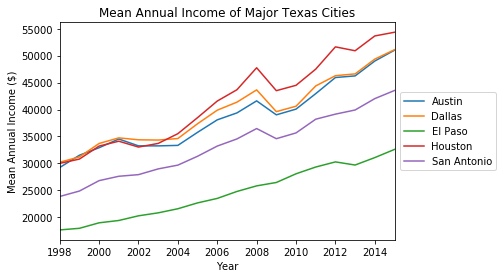

In [71]:
income = income_df.pivot(index="Year", columns="City", values="Income")
select  =["Austin", "Dallas", "El Paso", "Houston", "San Antonio"]

ax = income[select].plot()
lgd = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Mean Annual Income ($)")
plt.title("Mean Annual Income of Major Texas Cities")
plt.savefig("PNG Files\\Annual_income", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

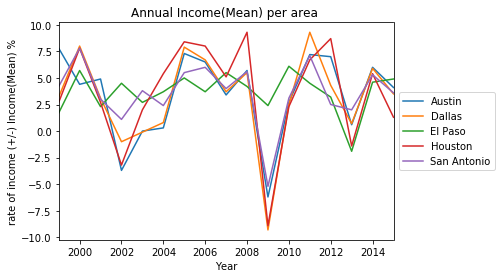

In [72]:
income_pct=round(income.pct_change()*100,1)
income_pct=income_pct.iloc[1:]

ax=income_pct[select].plot()
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('rate of income (+/-) Income(Mean) %')
plt.title('Annual Income(Mean) per area ')
plt.savefig('PNG Files\\Anuual Income Change%', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

Population Data Clean UP

In [73]:
# Clean Unneeded Data 
for i in population_df.columns:
    if len(population_df[i].unique()) ==1:
        population_df=population_df.drop(i, axis=1)

population_df['Population'] = population_df['Population'].str.replace(',', '')
population_df['Population'] = population_df['Population'].astype(int)
       
# Merge Population Data to Master Data Frame and Export Final CSVs at the Monthly and Yearly Levels 
master_df = pd.merge(master_df, population_df, how="left", on=["Year"])
monthly_data = master_df.groupby(['City','Year','Month']).mean()
monthly_data.to_csv('CSV Files\\Output\\Monthly Data.csv',index=True)
yearly_data = master_df.groupby(['Year','City']).mean()
yearly_data = yearly_data.drop(yearly_data.columns[[0]], axis=1)
yearly_data.to_csv('CSV Files\\Output\\Annual Data.csv',index=True)

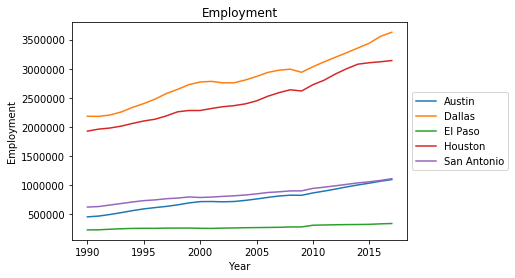

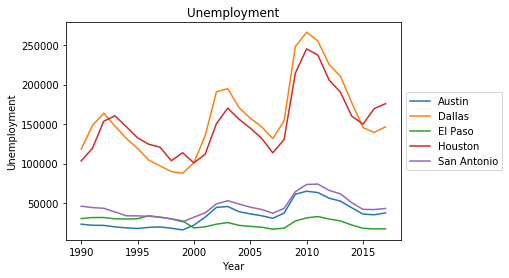

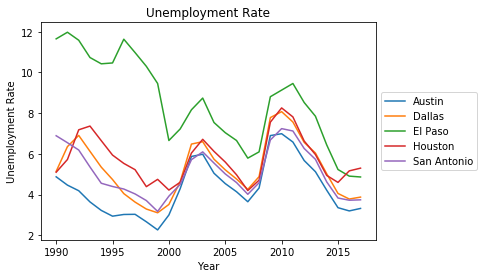

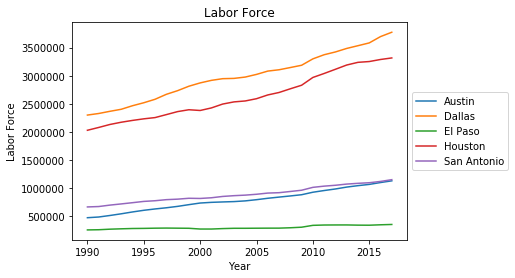

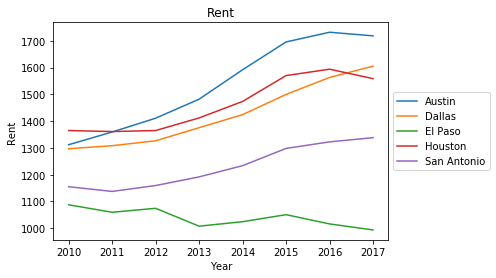

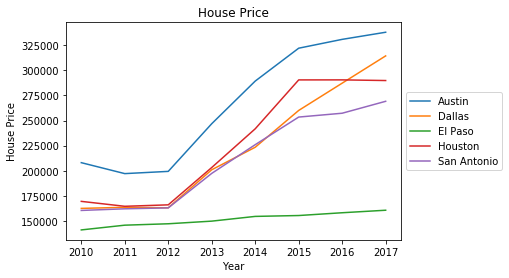

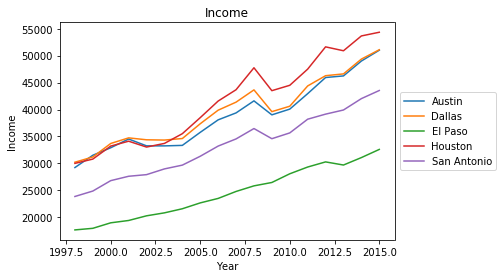

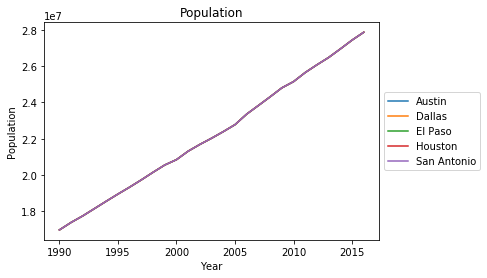

In [74]:
for data in yearly_data:
    TexasWFC_plot=yearly_data.reset_index()
    data_df=TexasWFC_plot.pivot(index='Year', columns='City', values=data)
    data_df=data_df[select]
    ax=data_df.plot()
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel(f'{data}')
    plt.title(f'{data}')
    plt.autoscale(enable=True, axis='x')
    plt.savefig(f'PNG Files\\TexasWFC {data}', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [75]:
# Make Data Frames for Years of Intrest with Zillow Data
yearly_data=pd.read_csv('CSV Files/Output/Annual Data.csv', index_col='Year')
years=set(yearly_data.index.values.tolist())
years=[year for year in years][-8:-2]

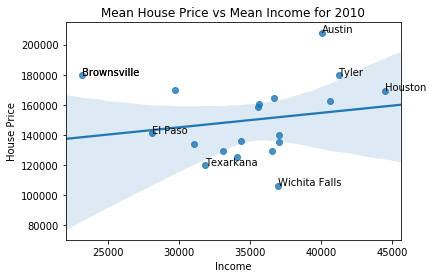

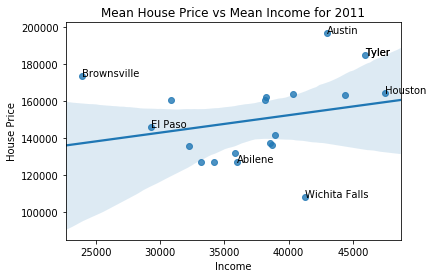

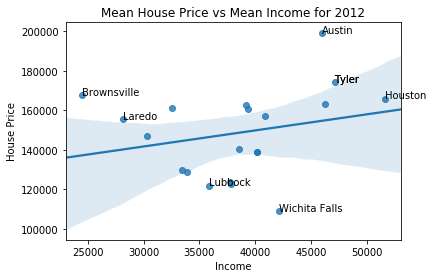

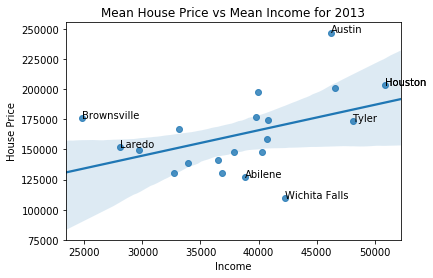

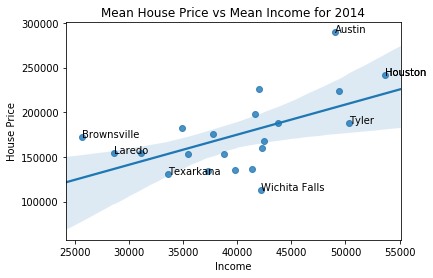

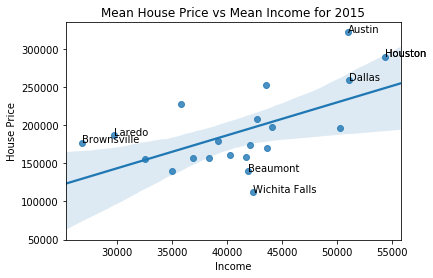

In [76]:
# plot of income vs House price 
years=set(yearly_data.index.values.tolist())
years=[int(year) for year in years][-8:-2]

for year in years:
    sns.regplot(data=yearly_data.loc[year], x='Income', y='House Price',)
    plt.title(f'Mean House Price vs Mean Income for {year}')
    
    # Annotate part 1 
    notate=2
    data=yearly_data.loc[year].sort_values('Income', ascending=False).dropna().iloc[:notate]
    for note in range(notate):
        
        city=data['City'].iloc[note]
        x   =data['Income'].iloc[note]
        y   =data['House Price'].iloc[note]

        plt.annotate(f'{city}', xy=(x, y))
        
    data=yearly_data.loc[year].sort_values('Income', ascending=False).dropna().iloc[notate*-1:]
    for note in range(notate):
        
        city=data['City'].iloc[note]
        x=data['Income'].iloc[note]
        y=data['House Price'].iloc[note]
        
        plt.annotate(f'{city}', xy=(x, y))
        
    # Annotate part 2 
    notate=2
    data=yearly_data.loc[year].sort_values('House Price', ascending=False).dropna().iloc[:notate]
    for note in range(notate):
        
        
        city=data['City']  .iloc[note]
        x   =data['Income'].iloc[note]
        y   =data['House Price'].iloc[note]

        plt.annotate(f'{city}', xy=(x, y))
        
    data=yearly_data.loc[year].sort_values('House Price', ascending=False).dropna().iloc[notate*-1:]    
    for note in range(notate):
        
        city=data['City'].iloc[note]
        x   =data['Income'].iloc[note]
        y   =data['House Price'].iloc[note]
        
        plt.annotate(f'{city}', xy=(x, y))

    
    plt.savefig(f'PNG Files\\Mean House Price vs Mean Income for {year}')
    
             
    plt.show()

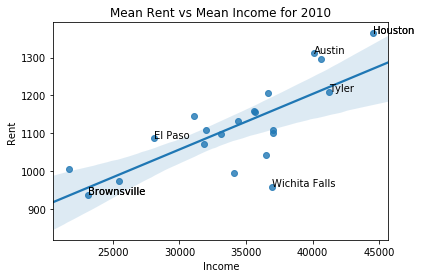

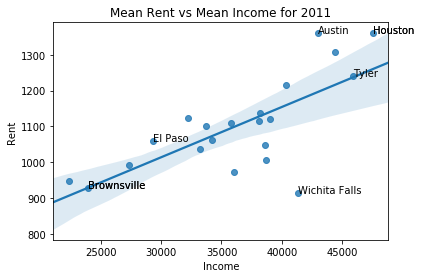

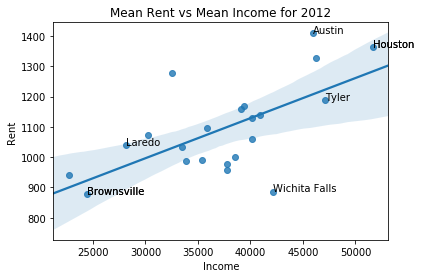

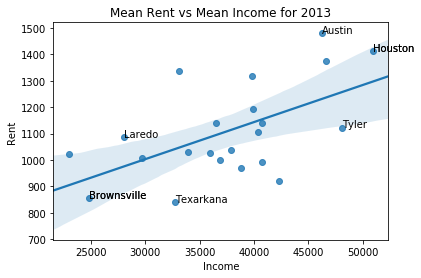

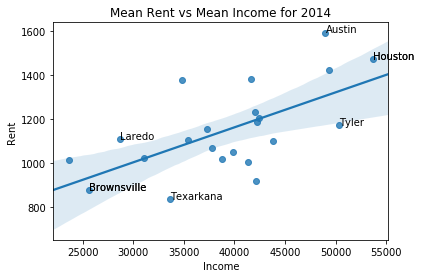

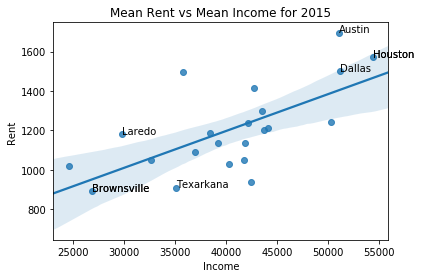

In [77]:
# plot of income vs Rent 

for year in years:
    sns.regplot(data=yearly_data.loc[year], x='Income', y='Rent')
    plt.title(f'Mean Rent vs Mean Income for {year}')
    
    # Annotate part 1 
    notate=2
    data=yearly_data.loc[year].sort_values('Income', ascending=False).dropna().iloc[:notate]
    for note in range(notate):
        
        city=data['City'].iloc[note]
        x   =data['Income'].iloc[note]
        y   =data['Rent'].iloc[note]

        plt.annotate(f'{city}', xy=(x, y))
        
    data=yearly_data.loc[year].sort_values('Income', ascending=False).dropna().iloc[notate*-1:]
    for note in range(notate):
        
        city=data['City'].iloc[note]
        x=data['Income'].iloc[note]
        y=data['Rent'].iloc[note]
        
        plt.annotate(f'{city}', xy=(x, y))
        
    # Annotate part 2 
    notate=2
    data=yearly_data.loc[year].sort_values('Rent', ascending=False).dropna().iloc[:notate]
    for note in range(notate):
        
        
        city=data['City']  .iloc[note]
        x   =data['Income'].iloc[note]
        y   =data['Rent'].iloc[note]

        plt.annotate(f'{city}', xy=(x, y))
        
    data=yearly_data.loc[year].sort_values('Rent', ascending=False).dropna().iloc[notate*-1:]    
    for note in range(notate):
        
        city=data['City'].iloc[note]
        x   =data['Income'].iloc[note]
        y   =data['Rent'].iloc[note]
        
        plt.annotate(f'{city}', xy=(x, y))
    
    plt.savefig(f'PNG Files\\Mean Rent vs Mean Income for {year}')
    plt.show()

In [78]:
# Make Data Frames of Data by Year of Years of Interest with the Zillow Data
Y2010 =yearly_data.loc[2010].dropna()
Y2011 =yearly_data.loc[2011].dropna()
Y2012 =yearly_data.loc[2012].dropna()
Y2013 =yearly_data.loc[2013].dropna()
Y2014 =yearly_data.loc[2014].dropna()
Y2015 =yearly_data.loc[2015].dropna()

In [79]:
# Run Analyses and Creat Data Frame
rent_10 = stats.pearsonr(Y2010['Income'], Y2010['Rent'])
price_10 = stats.pearsonr(Y2010['Income'], Y2010['House Price'])
rent_11 = stats.pearsonr(Y2011['Income'], Y2011['Rent'])
price_11 = stats.pearsonr(Y2011['Income'], Y2011['House Price'])
rent_12 = stats.pearsonr(Y2012['Income'], Y2012['Rent'])
price_12 = stats.pearsonr(Y2012['Income'], Y2012['House Price'])
rent_13 = stats.pearsonr(Y2013['Income'], Y2013['Rent'])
price_13 = stats.pearsonr(Y2013['Income'], Y2013['House Price'])
rent_14 = stats.pearsonr(Y2014['Income'], Y2014['Rent'])
price_14 = stats.pearsonr(Y2014['Income'], Y2014['House Price'])
rent_15 = stats.pearsonr(Y2015['Income'], Y2015['Rent'])
price_15 = stats.pearsonr(Y2015['Income'], Y2015['House Price'])

d = {'Year': [2010,2011,2012,2013,2014,2015],
     'Rent Analyses': [rent_10, rent_11, rent_12, rent_13, rent_14, rent_15],
     'House Price Analyses': [price_10, price_11, price_12, price_13, price_14, price_15]}
pearsonr_df = pd.DataFrame(data=d)
pearsonr_df

,House Price Analyses,Rent Analyses,Year
0,"(0.252433183105, 0.312214991809)","(0.715551964316, 0.000841305889669)",2010
1,"(0.29124347082, 0.240968104513)","(0.683166234131, 0.00177741958695)",2011
2,"(0.24604532124, 0.29570774311)","(0.610645616107, 0.00423924693699)",2012
3,"(0.439288963603, 0.0526357598746)","(0.58602673665, 0.00662112352756)",2013
4,"(0.566420061534, 0.00742891535366)","(0.631922377928, 0.00211874491419)",2014
5,"(0.577360597409, 0.00613234941092)","(0.658175118828, 0.00118066732054)",2015
